# Binning data with numpy

This is a note on binning data in numpy.

## 1D case

Lets define some imports and data

In [7]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt

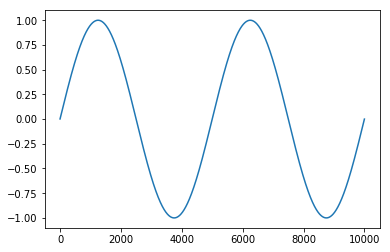

In [53]:

# linear x range
x = np.arange(1, 10001)
# define a period for our y data
period = len(x)/2
# y is the sine of x with period = len(x)/2
y = np.sin(2 * np.pi * x / period)
# plot x against y
plot = plt.plot(x, y)

### Histogram

A histogram produces the number of elements in a given bin:

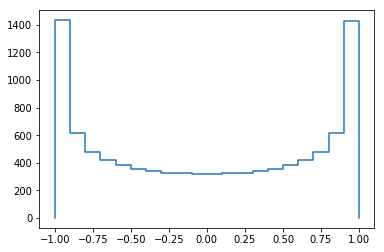

In [54]:
# set up some bins
bins = np.arange(-1, 1.1, 0.1)
# get a histogram
hist, edges = np.histogram(y, bins=bins)
# get widths of the bins (even though constant in this case)
widths = edges[1:] - edges[:-1]
# get centers (left + width) but not the last edge
centers = edges[:-1] + widths
# generate bars (could use plt.hist)
xbars = np.repeat(edges, 2)
ybars = np.concatenate([[0], np.repeat(hist, 2), [0]])
# plot the histogram
plot = plt.plot(xbars, ybars)

### Down sampling data

Averaging or summing the data in each bin to reduce the resolution of the data - if and only if data is already binned in linear bins!

In [55]:
# set up number of bins required
Nbin = 20
# get the width in bins
binpix = int(len(x)/Nbin)
# make 2D array size = (width, size/width)
binning_x = x.reshape((binpix, int(len(x)/binpix)))
binning_y = y.reshape((binpix, int(len(y)/binpix)))
# get the mean of bin values
mean_sample_x = np.mean(binning_x, axis=1)
mean_sample_y = np.mean(binning_y, axis=1)



Now lets plot the results:

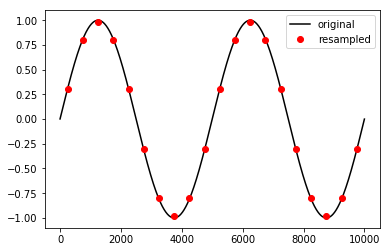

In [28]:
# plot sum plot
plot1 = plt.plot(x, y, color='k', label='original')
plot2 = plt.plot(mean_sample_x, mean_sample_y, color='r', marker='o',
                 linestyle='none', label='resampled')
# legend
legend = plt.legend(loc=0)

## 2D case histogram

Using two 1D arrays we can work out the frequency that pairs appear in the two 1D arrays. 

First we set up some data (two 1D gaussian arrays with mean and width): 


In [106]:
# define x and y
x = np.random.normal(30, 4, 100000)
y = np.random.normal(50, 4, 100000)
# define the number of bins we want in each axis
xbins, ybins = 32, 32

Then we can work out the 2D histogram:

In [107]:
hist, edges1, edges2 = np.histogram2d(x, y, bins=(xbins, ybins))

Then we can plot the result:

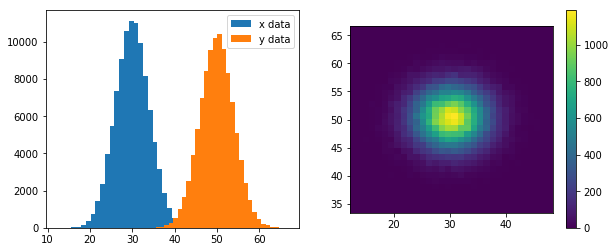

In [108]:
# set up plot
fig = plt.figure(figsize=(10, 4))
frame1 = plt.subplot(121)
frame2 = plt.subplot(122)

# plot the x and y points
frame1.hist(x, bins=xbins, label='x data')
frame1.hist(y, bins=ybins, label='y data')
frame1.legend(loc=0)
# plot the 2D histogram
extent = [np.min(edges1), np.max(edges1), np.min(edges2),  np.max(edges2)]
im = frame2.imshow(hist, extent=extent)
cb = plt.colorbar(im, ax=frame2)

## 2D case - down sampling

Lets define some data (a gaussian centered on the center of the "image" with a full-width half maximum of 25% of the image width)

In [56]:
# define some limits for our 2D array (image)
xlow, xhigh = 0, 512
ylow, yhigh = 0, 512
# find the centers and widths (widths = 0.25 of image)
cent_x, cent_y = 0.5*(xhigh - xlow), 0.5 * (yhigh - ylow)
wid_x, wid_y = 0.25*(xhigh - xlow), 0.25 * (yhigh - ylow)
# get dimensions
ndim1, ndim2 = xhigh- xlow, yhigh - ylow
# get x and y pixel locations
x = np.repeat(np.arange(xlow, xhigh), ndim2).reshape((ndim1, ndim2))
y = np.tile(np.arange(ylow, yhigh), ndim1).reshape((ndim1, ndim2))
# define our image as a gaussian
part1, part2 = (x-cent_x)/wid_x, (y-cent_y)/wid_y
z = np.exp(-0.5*(part1**2 + part2**2))


Now lets plot this:

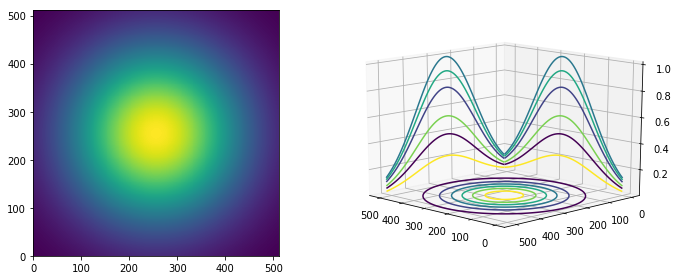

In [57]:
# import needed
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.cm as cm

# set up figure
fig = plt.figure(figsize=(10, 4))
frame1 = plt.subplot(121)
frame2 = plt.subplot(122, projection='3d')
# plot 2D image
frame1.imshow(z, extent=[xlow, xhigh, ylow, yhigh])
# plot 3D contour projections
frame2.contour(x, y, z, zdir='z', offset=0)
frame2.contour(x, y, z, zdir='x', offset=xhigh)
frame2.contour(x, y, z, zdir='y', offset=ylow)
frame2.view_init(15, 135)
fig.tight_layout()


Using this function we can down sample:

In [109]:
# binning function from J.F. Sebastian:
# https://stackoverflow.com/a/29042041/7858439
def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    m = np.arange(0,100,1).reshape((10,10))
    n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean', 'max', 'min', 'std', 'var']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(axis=-1*(i+1))
    return ndarray

# set up bin size
xbins1 = 32
ybins1 = 32
# use binning function
z_binned1 = bin_ndarray(z, (xbins1, ybins1), 'mean')

# set up a second bin size
xbins2 = 8
ybins2 = 8
z_binned2 = bin_ndarray(z, (xbins2, ybins2), 'mean')

Which produces an image like the one below on the right:

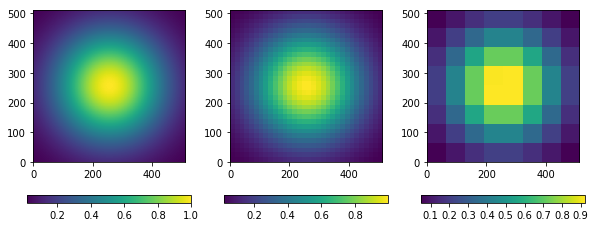

In [111]:
# set up figure
fig = plt.figure(figsize=(10, 4))
frame1 = plt.subplot(131)
frame2 = plt.subplot(132)
frame3 = plt.subplot(133)
# plot original
im1 = frame1.imshow(z, extent=[xlow, xhigh, ylow, yhigh])
cb1 = plt.colorbar(im1, ax=frame1, orientation='horizontal')
im2 = frame2.imshow(z_binned1, extent=[xlow, xhigh, ylow, yhigh])
cb2 = plt.colorbar(im2, ax=frame2, orientation='horizontal')
im3 = frame3.imshow(z_binned2, extent=[xlow, xhigh, ylow, yhigh])
cb3 = plt.colorbar(im3, ax=frame3, orientation='horizontal')

### Sources

- [Numpy binning in N dimensions](https://stackoverflow.com/a/29042041/7858439)

- [Matplotlib - 2D and 3D Plotting in IPython](http://jeffskinnerbox.me/notebooks/matplotlib-2d-and-3d-plotting-in-ipython.html)